# Ensemble Learning Workbook

In [14]:
%pylab inline
import numpy as np
import sklearn as sk

Populating the interactive namespace from numpy and matplotlib


/home/sam/.envs/ml/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [15]:
""" Import digits dataset. """
# http://scikit-learn.org/stable/auto_examples/datasets/plot_digits_last_image.html
from sklearn.datasets import load_digits
digits = load_digits()

In [16]:
def convert_features_used_to_image_locations(features_used, clf):
    features_used_as_image = np.zeros(64)
    for f in features_used:
        features_used_as_image[f] += 1
    features_used_as_image = features_used_as_image.reshape((8,8))
    locations_of_decision_points = np.argwhere(features_used_as_image > 0)
    return [features_used_as_image, locations_of_decision_points]


In [17]:
def plot_decision_points_on_image(ax, features_used_as_image, locations_of_decision_points):
    [ax.plot(x,y,'r*', ms=15*features_used_as_image[x,y]) for [x,y] in locations_of_decision_points]

# Random Forests

Generally speaking, a random forest is an ensmble learner where the weak learners are decision trees.

Original paper on decision trees:  [Ho, 1995](http://ieeexplore.ieee.org/xpl/login.jsp?arnumber=598994) ([pdf](ftp://cm.bell-labs.com/who/tkh/papers/odt.pdf))

Python's scikit-learn includes most of what we discussed pre-made in its [ensemble](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble) library.

Classes to run [Boosting (via AdaBoost)](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier) and [Bagging](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier) on arbitrary classifiers are given.
However, we will be focusing particularly on a few of the random forest functions given in that sklearn library.


### Bagging

In [18]:
""" Random forests made of bagged decision trees. """
# http://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10, max_depth=2, n_jobs=-1)
clf = clf.fit(digits.data, digits.target)
score = clf.score(digits.data, digits.target)

In [19]:
""" Pull out decision boundaries from all contained trees. """
features_used_as_image = np.zeros((8,8))
locations_of_decision_points = []

for est in clf.estimators_:  #for each weak learner
    features_used_in_this_tree = [f for f in est.tree_.feature if f != -2]
    [features_used_as_image_in_this_tree, locations_of_decision_points_in_this_tree] = \
        convert_features_used_to_image_locations(features_used_in_this_tree, est)
    features_used_as_image += features_used_as_image_in_this_tree
    locations_of_decision_points += list(locations_of_decision_points_in_this_tree)

locations_of_decision_points = list(set([tuple(c) for c in locations_of_decision_points]))
print(locations_of_decision_points)

[(6, 6), (7, 6), (4, 4), (6, 3), (0, 6), (1, 5), (7, 5), (7, 4), (3, 6), (3, 4), (4, 2), (2, 5), (4, 1), (1, 1), (5, 3)]


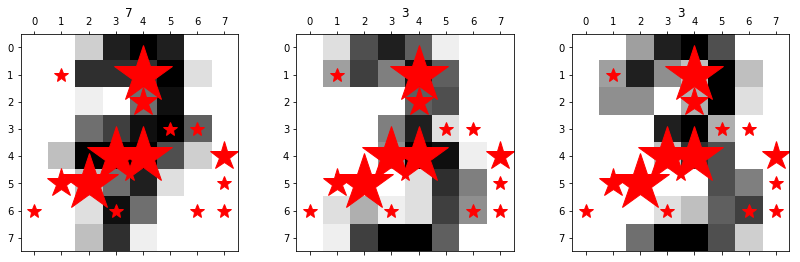

In [20]:
""" Plot 3 random digits, with decision boundaries labeled using ensemble learner. """

N = len(digits.data)
samples_to_show = np.random.randint(0,N,3)
f, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
f.set_figwidth(14)
ax1.set_title(digits.target[samples_to_show[0]])
ax1.matshow(digits.images[samples_to_show[0]], cmap=cm.gray_r)
plot_decision_points_on_image(ax1, features_used_as_image, locations_of_decision_points)

ax2.set_title(digits.target[samples_to_show[1]])
ax2.matshow(digits.images[samples_to_show[1]], cmap=cm.gray_r)
plot_decision_points_on_image(ax2, features_used_as_image, locations_of_decision_points)

ax3.set_title(digits.target[samples_to_show[2]])
ax3.matshow(digits.images[samples_to_show[2]], cmap=cm.gray_r)
plot_decision_points_on_image(ax3, features_used_as_image, locations_of_decision_points)

### Boosting

1 0.5141903171953256 0.028137683868408203
2 0.6143572621035058 0.04188346862792969
3 0.763494713411241 0.051924943923950195
4 0.7957707289927657 0.06554341316223145
5 0.8324986087924319 0.0886387825012207
6 0.8759042849193099 0.09650087356567383
7 0.8914858096828047 0.12354683876037598
8 0.9170840289371174 0.1335749626159668
9 0.9326655537006121 0.14403700828552246
10 0.9404563160823595 0.15281987190246582
11 0.9532554257095158 0.17506861686706543
12 0.9599332220367279 0.18672752380371094
13 0.9621591541457986 0.25537872314453125
14 0.9716193656093489 0.25601840019226074
15 0.9766277128547579 0.23185467720031738
16 0.9794101279910963 0.2504417896270752
17 0.9855314412910406 0.2711353302001953
18 0.986644407345576 0.31425046920776367
19 0.989983305509182 0.29848814010620117
20 0.9922092376182526 0.29921650886535645
21 0.9938786867000556 0.3837292194366455
22 0.9955481357818586 0.3451375961303711
23 0.9961046188091264 0.3488810062408447
24 0.9972175848636616 0.3705129623413086
25 0.99833

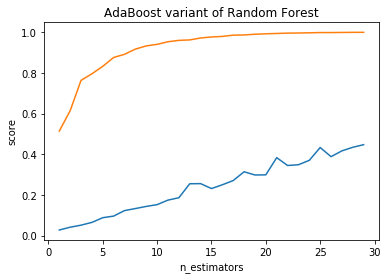

In [32]:
""" Boosing """
# http://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting
from sklearn.ensemble import GradientBoostingClassifier
import time

scores = []
times = []
list_of_n_estimators = range(1,30)
for n in list_of_n_estimators: # for n_estimators in [1:15]
    temp_scores = []
    start = time.time()
    for i in range(1):  # repeat this 5 times
        clf = GradientBoostingClassifier(n_estimators=n, learning_rate=0.6,
            max_depth=2, random_state=0, max_features=3).fit(digits.data, digits.target)
        score = clf.score(digits.data, digits.target)
        temp_scores.append(score)
    avg_score = float(sum(temp_scores))/len(temp_scores)
    scores.append(avg_score)
    elapsed = time.time() - start
    times.append(elapsed)
    print(n, avg_score, elapsed)

ax = plot(list_of_n_estimators, times)
plot(list_of_n_estimators, scores)
xlabel("n_estimators")
ylabel("score")
title("AdaBoost variant of Random Forest")

# Regarding learning rate:  http://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting-shrinkage


sklearn on selecting the number of boosting iterations using [out-of-bag estimates](# regarding selection of number of iterations: 
http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_oob.html#example-ensemble-plot-gradient-boosting-oob-py)

In [18]:
# Challenge: Add the time it takes to train and test a learner to the previous "n_estimators vs score" graph
# Play with the 'max features' in a similar way.  (i.e., look for a good value for it)
# What are the parameters of the best GradientBoostingClassifier you can make? 
#   (and did you split your data into train and test sets?)

In [19]:
# Graph the effect the number of estimators has on performance where n_estimators is in [1,50]

In [20]:
# Explore the relation between n_estimators and learning_rate

In [21]:
# Pick a good set of paramters (n_estimators, learning_rate, max_depth)

## Other Variants and Final Challenges:

In [22]:
# As in Ho 1995, add processed features and re-train a learner of your choice.

In [23]:
# Train/test split.  (careful so all classes are represented in both data sets)

In [24]:
""" Very random trees.  (even the decisions are random)"""
# http://scikit-learn.org/stable/modules/ensemble.html#extremely-randomized-trees
# Get ExtraTreesClassifier working on digits dataset.  Pick some good parameters

' Very random trees.  (even the decisions are random)'

In [25]:
# Compare performance of ExtraTreesClassifier to RandomForestClassifier

In [27]:
""" Play with AdaBoost or Bagging objects directly """
# if you aren't already, switch over to using the AdaBoost or Bagging Classifiers given in sklearn.ensemble to create a forest.
# Then use this framework to drop in a different classifier as a weak learner and compare your new predictor to your old random forest

' Play with AdaBoost or Bagging objects directly '

## Other Datasets:
* "the" MNIST [handwritten digits dataset](http://yann.lecun.com/exdb/mnist/)
* [Housing Prices](http://www.cs.toronto.edu/~delve/data/census-house/desc.html)